# Project2_3

## Data preparation

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import time
import datetime
import numpy as np
import itertools
import seaborn as sns
from scipy import stats
from colorama import Fore, Style

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import xgboost
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

In [2]:
crypto_data_folder = './g-research-crypto-forecasting/'
crypto_data = pd.read_csv(crypto_data_folder + 'train.csv')
asset_data = pd.read_csv(crypto_data_folder + 'asset_details.csv')

In [3]:
def get_initial_asset(asset_id, data=crypto_data):
    df = data[data['Asset_ID'] == asset_id].reset_index(drop=True)
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
    df = df.set_index('timestamp')
    return df

In [4]:
def prep_train_data(data, asset_id):
    train_df = pd.DataFrame(index=data.index)
    for i in range(16):
        train_df['Close(t-' + str(i) + ')/Close(t)'] = data.Close.shift(i) / data.Close
        train_df['(Close(t-' + str(i) + ')-Open(t-' + str(i) + '))/Close(t)'] = (data.Close.shift(i) - data.Open.shift(
            i)) / data.Close
        train_df['(High(t-' + str(i) + ')-Low(t-' + str(i) + '))/Close(t)'] = (data.High.shift(i) - data.Low.shift(
            i)) / data.Close
        train_df['Volume(t-' + str(i) + ')/Volume(t)'] = data.Volume.shift(i) / data.Volume
        train_df['VWAP(t-' + str(i) + ')/VWAP(t)'] = data.VWAP.shift(i) / data.VWAP
        train_df['VWAP(t-' + str(i) + ')/Close(t)'] = data.VWAP.shift(i) / data.Close
    train_df['Target1'] = np.log(data.Close.shift(-15) / data.Close)
    train_df['Target2'] = data.Close.shift(-15) / data.Close.rolling('1H').mean() - 1
    w = ['1H', '3H', '6H', '9H', '12H', '24H']
    for i in w:
        train_df['mean(VWAP(' + i + '))/Close(t)'] = data.VWAP.rolling(i).mean() / data.Close
        train_df['mean(Count(' + i + '))/Count(t)'] = data.Count.rolling(i).mean() / data.Count
        train_df['mean(Volume(' + i + '))/Volume(t)'] = data.Volume.rolling(i).mean() / data.Volume
        train_df['min(Close(' + i + '))/Close(t)'] = data.Close.rolling(i).min() / data.Close
        train_df['max(Close(' + i + '))/Close(t)'] = data.Close.rolling(i).max() / data.Close
        train_df['std(VWAP(' + i + '))/Close(t)'] = data.VWAP.rolling(i).std() / data.Close
        train_df['std(Count(' + i + '))/Count(t)'] = data.Count.rolling(i).std() / data.Count
        train_df['std(Volume(' + i + '))/Volume(t)'] = data.Volume.rolling(i).std() / data.Volume
        train_df['std(Close(' + i + '))/Close(t)'] = data.Close.rolling(i).std() / data.Close
    w1 = ['15min', '30min', '1H', '3H']
    for i in w1:
        train_df['mean(VWAP(' + i + '))/mean(VWAP(24H))'] = data.VWAP.rolling(i).mean() / data.VWAP.rolling(
            '24H').mean()
        train_df['mean(Count(' + i + '))/mean(Count(24H))'] = data.Count.rolling(i).mean() / data.Count.rolling(
            '24H').mean()
        train_df['mean(Volume(' + i + '))/mean(Volume(24H))'] = data.Volume.rolling(i).mean() / data.Volume.rolling(
            '24H').mean()
        train_df['mean(High(' + i + '))/mean(High(24H))'] = data.High.rolling(i).mean() / data.High.rolling(
            '24H').mean()
        train_df['mean(Low(' + i + '))/mean(Low(24H))'] = data.Low.rolling(i).mean() / data.Low.rolling('24H').mean()
        train_df['mean(Close(' + i + '))/mean(Close(24H))'] = data.Close.rolling(i).mean() / data.Close.rolling(
            '24H').mean()
        train_df['mean(Low(' + i + '))/mean(VWAP(24H))'] = data.Low.rolling(i).mean() / data.VWAP.rolling('24H').mean()
        train_df['mean(High(' + i + '))/mean(VWAP(24H))'] = data.High.rolling(i).mean() / data.VWAP.rolling(
            '24H').mean()
        train_df['mean(Close(' + i + '))/mean(VWAP(24H))'] = data.Close.rolling(i).mean() / data.VWAP.rolling(
            '24H').mean()
        train_df['std(VWAP(' + i + '))/mean(VWAP(24H))'] = data.VWAP.rolling(i).std() / data.VWAP.rolling('24H').mean()
        train_df['std(Close(' + i + '))/mean(VWAP(24H))'] = data.Close.rolling(i).std() / data.VWAP.rolling(
            '24H').mean()
        train_df['std(Count(' + i + '))/mean(Count(24H))'] = data.Count.rolling(i).std() / data.Count.rolling(
            '24H').mean()
        train_df['std(Volume(' + i + '))/mean(Volume(24H))'] = data.Volume.rolling(i).std() / data.Volume.rolling(
            '24H').mean()
    train_df['date'] = data.index
    train_df['day_of_week'] = train_df['date'].apply(datetime.datetime.weekday)
    train_df['day_of_week'] += 1
    train_df = train_df.drop(columns=['date'])
    train_df['hour'] = data.index.hour
    train_df['minute'] = data.index.minute
    return train_df

In [5]:
bitcoin_raw = get_initial_asset(asset_id=1)
bitcoin = prep_train_data(bitcoin_raw, asset_id=1)

data_raw = bitcoin_raw
data = bitcoin

C:\Users\Crews\AppData\Local\Temp/ipykernel_25432/633400713.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df['mean(Volume(' + i + '))/Volume(t)'] = data.Volume.rolling(i).mean() / data.Volume
C:\Users\Crews\AppData\Local\Temp/ipykernel_25432/633400713.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df['min(Close(' + i + '))/Close(t)'] = data.Close.rolling(i).min() / data.Close
C:\Users\Crews\AppData\Local\Temp/ipykernel_25432/633400713.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is 

In [6]:
data_1 = data.tail(10016)
data_1.drop(data_1.tail(16).index, inplace=True)
print('Any null data: ', data_1.isna().values.any())
Y1 = pd.DataFrame(data_1.Target1, index=data_1.index)
Y2 = pd.DataFrame(data_1.Target2, index=data_1.index)
X = data_1.drop(['Target1', 'Target2'], axis=1)
X = X.drop(['Close(t-0)/Close(t)', 'VWAP(t-0)/VWAP(t)', 'Volume(t-0)/Volume(t)'], axis=1)

Any null data:  False


C:\Users\Crews\anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [7]:
X_train, X_test, Y1_train, Y1_test, Y2_train, Y2_test = train_test_split(X, Y1, Y2, test_size=0.2, shuffle=False)
print('All data size: %d' % X.size)
print('Train data size: %d' % X_train.size)
print('Test data size: %d' % X_test.size)

All data size: 2020000
Train data size: 1616000
Test data size: 404000


## Regressor and params

In [11]:
reg = xgboost.XGBRegressor()

In [12]:
class BlockingTimeSeriesSplit():
    def __init__(self, n_splits):
        self.n_splits = n_splits

    def get_n_splits(self, X, y, groups):
        return self.n_splits

    def split(self, X, y=None, groups=None):
        n_samples = len(X)
        k_fold_size = n_samples // self.n_splits
        indices = np.arange(n_samples)

        margin = 0
        for i in range(self.n_splits):
            start = i * k_fold_size
            stop = start + k_fold_size
            mid = int(0.8 * (stop - start)) + start
            yield indices[start: mid], indices[mid + margin: stop]

In [20]:
eta_set = [0.001, 0.003, 0.01, 0.03, 0.1, 0.3]
nest_set = [100, 300, 500, 700, 1000, 1300, 1500]
max_depth_set = [2, 3, 4, 5 ,6, 7, 8, 9]
subsample_set = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
colsample_set = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
lambda_set = [1, 5, 10, 50, 100]
alpha_set = [0, 0.001, 0.005, 0.01, 0.05, 0.1]
gamma_set = [0, 0.1, 0.2, 0.3, 0.4]
gamma_set_new = [0, 0.1]
child_set = [1, 2, 3, 4, 5]

## step by step grid search Y2 BlockingTimeSeriesSplit

### eta n_estimators tuning

In [14]:
eta_nest_params2 = {
    'eta': eta_set,
    'n_estimators': nest_set,
    'eval_metric': ['rmse'],
    'booster': ['gbtree'],
    'objective': ['reg:pseudohubererror']
}

In [12]:
# start = time.time()
# grid_eta_nest2 = GridSearchCV(estimator=reg, param_grid=eta_nest_params2, cv=BlockingTimeSeriesSplit(n_splits=7).split(X_train), scoring='neg_mean_squared_error')
# grid_eta_nest2.fit(X_train, Y2_train)
# tuning_time1 = time.time() - start

In [13]:
# print('Tuning time: ', datetime.timedelta(seconds=round(tuning_time1)))

In [14]:
# best_eta_nest2 = grid_eta_nest2.best_estimator_

In [15]:
# best_eta_nest2.save_model('models_tuning/eta_nest_tuning2.json')

In [16]:
# result_eta_nest2 = pd.DataFrame(grid_eta_nest2.cv_results_)
# result_eta_nest2.to_csv('cv_results/eta_nest2.csv')

In [17]:
result_eta_nest2 = pd.read_csv('cv_results/eta_nest2.csv')
result_eta_nest2

,Unnamed: 0,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_booster,param_eta,param_eval_metric,param_n_estimators,param_objective,...,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,mean_test_score,std_test_score,rank_test_score
0,0,0.381428,0.076285,0.008571,0.000727,gbtree,0.001,rmse,100,reg:pseudohubererror,...,-0.196761,-0.194774,-0.197011,-0.194859,-0.195985,-0.196883,-0.198326,-0.196371,0.001173,42
1,1,1.031572,0.143285,0.008000,0.000534,gbtree,0.001,rmse,300,reg:pseudohubererror,...,-0.124340,-0.122663,-0.124347,-0.122537,-0.123356,-0.124369,-0.125311,-0.123846,0.000946,41
2,2,1.488753,0.098210,0.008572,0.000730,gbtree,0.001,rmse,500,reg:pseudohubererror,...,-0.080410,-0.079009,-0.080313,-0.078805,-0.079422,-0.080397,-0.081045,-0.079914,0.000775,39
3,3,1.977856,0.144182,0.008286,0.000700,gbtree,0.001,rmse,700,reg:pseudohubererror,...,-0.052765,-0.051602,-0.052626,-0.051376,-0.051853,-0.052734,-0.053197,-0.052308,0.000639,38
4,4,2.808284,0.165500,0.007002,0.000534,gbtree,0.001,rmse,1000,reg:pseudohubererror,...,-0.028535,-0.027658,-0.028387,-0.027447,-0.027780,-0.028496,-0.028791,-0.028156,0.000479,36
5,5,3.553570,0.139146,0.006857,0.000350,gbtree,0.001,rmse,1300,reg:pseudohubererror,...,-0.015638,-0.014979,-0.015505,-0.014801,-0.015039,-0.015600,-0.015798,-0.015337,0.000360,34
6,6,4.264999,0.362194,0.007573,0.000728,gbtree,0.001,rmse,1500,reg:pseudohubererror,...,-0.010528,-0.009985,-0.010409,-0.009829,-0.010021,-0.010493,-0.010649,-0.010273,0.000297,33
7,7,0.290428,0.006321,0.007858,0.000350,gbtree,0.003,rmse,100,reg:pseudohubererror,...,-0.124212,-0.122536,-0.124220,-0.122410,-0.123228,-0.124242,-0.125183,-0.123719,0.000946,40
8,8,0.947571,0.112606,0.008000,0.000534,gbtree,0.003,rmse,300,reg:pseudohubererror,...,-0.034877,-0.033915,-0.034728,-0.033695,-0.034069,-0.034839,-0.035179,-0.034472,0.000527,37
9,9,1.603000,0.230768,0.008572,0.000728,gbtree,0.003,rmse,500,reg:pseudohubererror,...,-0.010490,-0.009948,-0.010372,-0.009793,-0.009984,-0.010456,-0.010611,-0.010236,0.000296,32


In [15]:
best_eta_nest2 = xgboost.XGBRegressor()
best_eta_nest2.load_model('models_tuning/eta_nest_tuning2.json')

In [16]:
best_params_eta_nest2 = best_eta_nest2.get_params()
best_eta2 = best_params_eta_nest2['eta']
best_nest2 = best_params_eta_nest2['n_estimators']

In [20]:
print('Best eta: ', best_eta2)
print('Best n_estimators: ', best_nest2)

Best eta:  0.01
Best n_estimators:  1500


### max_depth tuning

In [39]:
max_depth_params2 = {
    'eta': [best_eta2],
    'n_estimators': [best_nest2],
    'max_depth': max_depth_set,
    'eval_metric': ['rmse'],
    'booster': ['gbtree'],
    'objective': ['reg:pseudohubererror']
}

In [40]:
# start = time.time()
# grid_max_depth2 = GridSearchCV(estimator=reg, param_grid=max_depth_params2, cv=BlockingTimeSeriesSplit(n_splits=7).split(X_train), scoring='neg_mean_squared_error')
# grid_max_depth2.fit(X_train, Y2_train)
# tuning_time2 = time.time() - start

In [41]:
# print('Tuning time: ', datetime.timedelta(seconds=round(tuning_time2)))

Tuning time:  0:09:21


In [42]:
# best_model_max_depth2 = grid_max_depth2.best_estimator_

In [43]:
# best_model_max_depth2.save_model('models_tuning/max_depth_tuning2.json')

In [44]:
# result_max_depth2 = pd.DataFrame(grid_max_depth2.cv_results_)
# result_max_depth2.to_csv('cv_results/max_depth2.csv')

In [7]:
result_max_depth2 = pd.read_csv('cv_results/max_depth2.csv')

result_max_depth2[['param_max_depth', 'mean_test_score']].iloc[[1, 2, 3, 4]]

,param_max_depth,mean_test_score
1,3,-0.000011
2,4,-0.000011
3,5,-0.000012
4,6,-0.000012


In [17]:
best_model_max_depth2 = xgboost.XGBRegressor()
best_model_max_depth2.load_model('models_tuning/max_depth_tuning2.json')

In [18]:
best_params_max_depth2 = best_model_max_depth2.get_params()
best_max_depth2 = best_params_max_depth2['max_depth']

In [27]:
print('Best max_depth: ', best_max_depth2)

Best max_depth:  3


### subsample tuning

In [34]:
subsample_params2 = {
    'eta': [best_eta2],
    'n_estimators': [best_nest2],
    'max_depth': [best_max_depth2],
    'subsample': subsample_set,
    'eval_metric': ['rmse'],
    'booster': ['gbtree'],
    'objective': ['reg:pseudohubererror']
}

In [35]:
# start = time.time()
# grid_subsample2 = GridSearchCV(estimator=reg, param_grid=subsample_params2,
#                                cv=BlockingTimeSeriesSplit(n_splits=7).split(X_train), scoring='neg_mean_squared_error')
# grid_subsample2.fit(X_train, Y2_train)
# tuning_time3 = time.time() - start

In [36]:
# print('Tuning time: ', datetime.timedelta(seconds=round(tuning_time3)))

In [37]:
# best_model_subsample2 = grid_subsample2.best_estimator_

In [38]:
# best_model_subsample2.save_model('models_tuning/subsample_tuning2.json')

In [39]:
# result_subsample2 = pd.DataFrame(grid_subsample2.cv_results_)
# result_subsample2.to_csv('cv_results/subsample2.csv')

In [40]:
result_subsample2 = pd.read_csv('cv_results/subsample2.csv')
result_subsample2

,Unnamed: 0,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_booster,param_eta,param_eval_metric,param_max_depth,param_n_estimators,...,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,mean_test_score,std_test_score,rank_test_score
0,0,3.470861,0.250544,0.008276,0.000454,gbtree,0.01,rmse,3,1500,...,-0.000012,-0.000005,-0.000006,-0.000006,-0.000010,-0.000007,-0.000028,-0.000011,0.000007,1
1,1,4.307860,0.184106,0.007854,0.000641,gbtree,0.01,rmse,3,1500,...,-0.000019,-0.000006,-0.000007,-0.000007,-0.000011,-0.000007,-0.000028,-0.000012,0.000008,6
2,2,5.171585,0.285545,0.008273,0.000700,gbtree,0.01,rmse,3,1500,...,-0.000020,-0.000006,-0.000007,-0.000007,-0.000010,-0.000007,-0.000027,-0.000012,0.000008,9
3,3,5.591875,0.241642,0.008554,0.000496,gbtree,0.01,rmse,3,1500,...,-0.000018,-0.000007,-0.000008,-0.000007,-0.000010,-0.000007,-0.000026,-0.000012,0.000007,4
4,4,6.595737,0.297584,0.007989,0.000751,gbtree,0.01,rmse,3,1500,...,-0.000019,-0.000006,-0.000008,-0.000007,-0.000010,-0.000007,-0.000025,-0.000012,0.000007,8
5,5,7.329877,0.318149,0.008265,0.000700,gbtree,0.01,rmse,3,1500,...,-0.000021,-0.000007,-0.000008,-0.000008,-0.000010,-0.000007,-0.000024,-0.000012,0.000007,10
6,6,7.748298,0.423130,0.008559,0.000730,gbtree,0.01,rmse,3,1500,...,-0.000020,-0.000007,-0.000009,-0.000007,-0.000010,-0.000007,-0.000024,-0.000012,0.000006,7
7,7,7.971301,0.394201,0.008128,0.000634,gbtree,0.01,rmse,3,1500,...,-0.000020,-0.000007,-0.000008,-0.000008,-0.000010,-0.000007,-0.000024,-0.000012,0.000006,5
8,8,8.527438,0.460491,0.008563,0.000495,gbtree,0.01,rmse,3,1500,...,-0.000018,-0.000007,-0.000008,-0.000007,-0.000010,-0.000007,-0.000024,-0.000012,0.000006,3
9,9,9.064722,0.434060,0.008279,0.000442,gbtree,0.01,rmse,3,1500,...,-0.000017,-0.000007,-0.000006,-0.000007,-0.000010,-0.000008,-0.000024,-0.000011,0.000006,2


In [19]:
best_model_subsample2 = xgboost.XGBRegressor()
best_model_subsample2.load_model('models_tuning/subsample_tuning2.json')

In [20]:
best_params_subsample2 = best_model_subsample2.get_params()
best_subsample2 = best_params_subsample2['subsample']

In [43]:
print('Best subsample: ', best_subsample2)

Best subsample:  0.1


### colsample_bytree tuning

In [44]:
colsample_params2 = {
    'eta': [best_eta2],
    'n_estimators': [best_nest2],
    'max_depth': [best_max_depth2],
    'subsample': [best_subsample2],
    'colsample_bytree': colsample_set,
    'eval_metric': ['rmse'],
    'booster': ['gbtree'],
    'objective': ['reg:pseudohubererror']
}

In [45]:
# start = time.time()
# grid_colsample2 = GridSearchCV(estimator=reg, param_grid=colsample_params2,
#                                cv=BlockingTimeSeriesSplit(n_splits=7).split(X_train), scoring='neg_mean_squared_error')
# grid_colsample2.fit(X_train, Y2_train)
# tuning_time4 = time.time() - start

In [46]:
# print('Tuning time: ', datetime.timedelta(seconds=round(tuning_time4)))

In [47]:
# best_model_colsample2 = grid_colsample2.best_estimator_

In [48]:
# best_model_colsample2.save_model('models_tuning/colsample_tuning2.json')

In [49]:
# result_colsample2 = pd.DataFrame(grid_colsample2.cv_results_)
# result_colsample2.to_csv('cv_results/colsample2.csv')

In [50]:
result_colsample2 = pd.read_csv('cv_results/colsample2.csv')
result_colsample2

,Unnamed: 0,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_booster,param_colsample_bytree,param_eta,param_eval_metric,param_max_depth,...,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,mean_test_score,std_test_score,rank_test_score
0,0,2.803721,0.244053,0.009135,0.002031,gbtree,0.1,0.01,rmse,3,...,-0.000011,-0.000005,-0.000006,-0.000008,-0.00001,-0.000008,-0.000023,-0.000010,0.000006,1
1,1,2.723868,0.098075,0.013989,0.011064,gbtree,0.2,0.01,rmse,3,...,-0.000011,-0.000005,-0.000006,-0.000006,-0.00001,-0.000008,-0.000025,-0.000010,0.000006,2
2,2,2.750149,0.070100,0.008423,0.000500,gbtree,0.3,0.01,rmse,3,...,-0.000013,-0.000005,-0.000006,-0.000005,-0.00001,-0.000009,-0.000027,-0.000011,0.000007,7
3,3,2.818159,0.062574,0.007841,0.000628,gbtree,0.4,0.01,rmse,3,...,-0.000012,-0.000005,-0.000007,-0.000005,-0.00001,-0.000008,-0.000027,-0.000011,0.000007,5
4,4,2.981009,0.095369,0.008420,0.000489,gbtree,0.5,0.01,rmse,3,...,-0.000012,-0.000005,-0.000006,-0.000005,-0.00001,-0.000007,-0.000027,-0.000010,0.000007,3
5,5,3.132021,0.109926,0.008265,0.000689,gbtree,0.6,0.01,rmse,3,...,-0.000012,-0.000005,-0.000007,-0.000005,-0.00001,-0.000007,-0.000027,-0.000010,0.000007,4
6,6,3.419009,0.237352,0.010428,0.005152,gbtree,0.7,0.01,rmse,3,...,-0.000014,-0.000005,-0.000007,-0.000006,-0.00001,-0.000007,-0.000027,-0.000011,0.000007,9
7,7,3.487153,0.181308,0.008705,0.001162,gbtree,0.8,0.01,rmse,3,...,-0.000013,-0.000005,-0.000007,-0.000006,-0.00001,-0.000007,-0.000029,-0.000011,0.000008,10
8,8,3.496161,0.202691,0.008268,0.001028,gbtree,0.9,0.01,rmse,3,...,-0.000013,-0.000005,-0.000007,-0.000006,-0.00001,-0.000007,-0.000028,-0.000011,0.000007,8
9,9,3.582012,0.183045,0.008131,0.000641,gbtree,1.0,0.01,rmse,3,...,-0.000012,-0.000005,-0.000006,-0.000006,-0.00001,-0.000007,-0.000028,-0.000011,0.000007,6


In [21]:
best_model_colsample2 = xgboost.XGBRegressor()
best_model_colsample2.load_model('models_tuning/colsample_tuning2.json')

In [22]:
best_params_colsample2 = best_model_colsample2.get_params()
best_colsample2 = best_params_colsample2['colsample_bytree']

In [53]:
print('Best colsample_bytree: ', best_colsample2)

Best colsample_bytree:  0.1


### lambda tuning

In [54]:
lambda_params2 = {
    'eta': [best_eta2],
    'n_estimators': [best_nest2],
    'max_depth': [best_max_depth2],
    'subsample': [best_subsample2],
    'colsample_bytree': [best_colsample2],
    'lambda': lambda_set,
    'eval_metric': ['rmse'],
    'booster': ['gbtree'],
    'objective': ['reg:pseudohubererror']
}

In [55]:
# start = time.time()
# grid_lambda2 = GridSearchCV(estimator=reg, param_grid=lambda_params2,
#                                cv=BlockingTimeSeriesSplit(n_splits=7).split(X_train), scoring='neg_mean_squared_error')
# grid_lambda2.fit(X_train, Y2_train)
# tuning_time5 = time.time() - start

In [56]:
# print('Tuning time: ', datetime.timedelta(seconds=round(tuning_time5)))

In [57]:
# best_model_lambda2 = grid_lambda2.best_estimator_

In [58]:
# best_model_lambda2.save_model('models_tuning/lambda_tuning2.json')

In [59]:
# result_lambda2 = pd.DataFrame(grid_lambda2.cv_results_)
# result_lambda2.to_csv('cv_results/lambda2.csv')

In [60]:
result_lambda2 = pd.read_csv('cv_results/lambda2.csv')
result_lambda2

,Unnamed: 0,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_booster,param_colsample_bytree,param_eta,param_eval_metric,param_lambda,...,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,mean_test_score,std_test_score,rank_test_score
0,0,2.656155,0.188194,0.013275,0.011735,gbtree,0.1,0.01,rmse,1,...,-0.000011,-0.000005,-0.000006,-0.000008,-0.000010,-0.000008,-0.000023,-0.000010,0.000006,1
1,1,2.496301,0.059761,0.008270,0.000688,gbtree,0.1,0.01,rmse,5,...,-0.000009,-0.000005,-0.000007,-0.000006,-0.000010,-0.000010,-0.000028,-0.000011,0.000007,2
2,2,2.571019,0.162147,0.008409,0.000481,gbtree,0.1,0.01,rmse,10,...,-0.000009,-0.000005,-0.000007,-0.000006,-0.000010,-0.000010,-0.000031,-0.000011,0.000009,3
3,3,2.477906,0.175780,0.008137,0.000338,gbtree,0.1,0.01,rmse,50,...,-0.000007,-0.000004,-0.000009,-0.000004,-0.000012,-0.000009,-0.000032,-0.000011,0.000009,4
4,4,2.319294,0.056163,0.007705,0.000703,gbtree,0.1,0.01,rmse,100,...,-0.000010,-0.000005,-0.000011,-0.000005,-0.000015,-0.000011,-0.000038,-0.000013,0.000010,5


In [23]:
best_model_lambda2 = xgboost.XGBRegressor()
best_model_lambda2.load_model('models_tuning/lambda_tuning2.json')

In [24]:
best_params_lambda2 = best_model_lambda2.get_params()
best_lambda2 = best_params_lambda2['lambda']

In [63]:
print('Best lambda: ', best_lambda2)

Best lambda:  1


### alpha tuning

In [64]:
alpha_params2 = {
    'eta': [best_eta2],
    'n_estimators': [best_nest2],
    'max_depth': [best_max_depth2],
    'subsample': [best_subsample2],
    'colsample_bytree': [best_colsample2],
    'lambda': [best_lambda2],
    'alpha': alpha_set,
    'eval_metric': ['rmse'],
    'booster': ['gbtree'],
    'objective': ['reg:pseudohubererror']
}

In [65]:
# start = time.time()
# grid_alpha2 = GridSearchCV(estimator=reg, param_grid=alpha_params2,
#                             cv=BlockingTimeSeriesSplit(n_splits=7).split(X_train), scoring='neg_mean_squared_error')
# grid_alpha2.fit(X_train, Y2_train)
# tuning_time6 = time.time() - start

In [66]:
# print('Tuning time: ', datetime.timedelta(seconds=round(tuning_time6)))

In [67]:
# best_model_alpha2 = grid_alpha2.best_estimator_

In [68]:
# best_model_alpha2.save_model('models_tuning/alpha_tuning2.json')

In [69]:
# result_alpha2 = pd.DataFrame(grid_alpha2.cv_results_)
# result_alpha2.to_csv('cv_results/alpha2.csv')

In [70]:
result_alpha2 = pd.read_csv('cv_results/alpha2.csv')
result_alpha2

,Unnamed: 0,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_booster,param_colsample_bytree,param_eta,param_eval_metric,...,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,mean_test_score,std_test_score,rank_test_score
0,0,2.488448,0.036880,0.008266,0.000456,0.000,gbtree,0.1,0.01,rmse,...,-0.000011,-0.000005,-0.000006,-0.000008,-0.000010,-0.000008,-0.000023,-0.000010,0.000006,1
1,1,2.514022,0.046395,0.008120,0.000346,0.001,gbtree,0.1,0.01,rmse,...,-0.000011,-0.000005,-0.000006,-0.000007,-0.000010,-0.000009,-0.000023,-0.000010,0.000006,2
2,2,2.498304,0.080689,0.008409,0.000492,0.005,gbtree,0.1,0.01,rmse,...,-0.000010,-0.000005,-0.000006,-0.000006,-0.000010,-0.000010,-0.000027,-0.000010,0.000007,3
3,3,2.473149,0.085359,0.007850,0.000347,0.010,gbtree,0.1,0.01,rmse,...,-0.000009,-0.000004,-0.000006,-0.000006,-0.000010,-0.000010,-0.000030,-0.000011,0.000008,4
4,4,2.332284,0.028019,0.007574,0.000495,0.050,gbtree,0.1,0.01,rmse,...,-0.000007,-0.000005,-0.000010,-0.000004,-0.000012,-0.000010,-0.000038,-0.000013,0.000011,5
5,5,2.543150,0.365074,0.011859,0.010736,0.100,gbtree,0.1,0.01,rmse,...,-0.000011,-0.000005,-0.000012,-0.000004,-0.000014,-0.000013,-0.000044,-0.000015,0.000013,6


In [25]:
best_model_alpha2 = xgboost.XGBRegressor()
best_model_alpha2.load_model('models_tuning/alpha_tuning2.json')

In [26]:
best_params_alpha2 = best_model_alpha2.get_params()
best_alpha2 = best_params_alpha2['alpha']

In [73]:
print('Best alpha: ', best_alpha2)

Best alpha:  0


### gamma tuning

In [74]:
gamma_params2 = {
    'eta': [best_eta2],
    'n_estimators': [best_nest2],
    'max_depth': [best_max_depth2],
    'subsample': [best_subsample2],
    'colsample_bytree': [best_colsample2],
    'lambda': [best_lambda2],
    'alpha': [best_alpha2],
    'gamma': gamma_set,
    'eval_metric': ['rmse'],
    'booster': ['gbtree'],
    'objective': ['reg:pseudohubererror']
}

In [75]:
# start = time.time()
# grid_gamma2 = GridSearchCV(estimator=reg, param_grid=gamma_params2,
#                            cv=BlockingTimeSeriesSplit(n_splits=7).split(X_train), scoring='neg_mean_squared_error')
# grid_gamma2.fit(X_train, Y2_train)
# tuning_time7 = time.time() - start

In [76]:
# print('Tuning time: ', datetime.timedelta(seconds=round(tuning_time7)))

In [77]:
# best_model_gamma2 = grid_gamma2.best_estimator_

In [78]:
# best_model_gamma2.save_model('models_tuning/gamma_tuning2.json')

In [79]:
# result_gamma2 = pd.DataFrame(grid_gamma2.cv_results_)
# result_gamma2.to_csv('cv_results/gamma2.csv')

In [80]:
result_gamma2 = pd.read_csv('cv_results/gamma2.csv')
result_gamma2

,Unnamed: 0,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_booster,param_colsample_bytree,param_eta,param_eval_metric,...,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,mean_test_score,std_test_score,rank_test_score
0,0,2.829007,0.457486,0.008708,0.000697,0,gbtree,0.1,0.01,rmse,...,-0.000011,-0.000005,-0.000006,-0.000008,-0.000010,-0.000008,-0.000023,-0.000010,0.000006,1
1,1,2.751858,0.194455,0.008712,0.004200,0,gbtree,0.1,0.01,rmse,...,-0.000011,-0.000008,-0.000008,-0.000010,-0.000017,-0.000009,-0.000031,-0.000014,0.000008,2
2,2,2.473576,0.049976,0.006996,0.000014,0,gbtree,0.1,0.01,rmse,...,-0.000011,-0.000008,-0.000008,-0.000010,-0.000017,-0.000009,-0.000031,-0.000014,0.000008,2
3,3,2.487006,0.054328,0.006852,0.000347,0,gbtree,0.1,0.01,rmse,...,-0.000011,-0.000008,-0.000008,-0.000010,-0.000017,-0.000009,-0.000031,-0.000014,0.000008,2
4,4,2.532433,0.048314,0.007139,0.000841,0,gbtree,0.1,0.01,rmse,...,-0.000011,-0.000008,-0.000008,-0.000010,-0.000017,-0.000009,-0.000031,-0.000014,0.000008,2


In [27]:
best_model_gamma2 = xgboost.XGBRegressor()
best_model_gamma2.load_model('models_tuning/gamma_tuning2.json')

In [28]:
best_params_gamma2 = best_model_gamma2.get_params()
best_gamma2 = best_params_gamma2['gamma']

In [83]:
print('Best gamma: ', best_gamma2)

Best gamma:  0


### min_child_weight tuning

In [84]:
child_params2 = {
    'eta': [best_eta2],
    'n_estimators': [best_nest2],
    'max_depth': [best_max_depth2],
    'subsample': [best_subsample2],
    'colsample_bytree': [best_colsample2],
    'lambda': [best_lambda2],
    'alpha': [best_alpha2],
    'gamma': [best_gamma2],
    'min_child_weight': child_set,
    'eval_metric': ['rmse'],
    'booster': ['gbtree'],
    'objective': ['reg:pseudohubererror']
}

In [85]:
# start = time.time()
# grid_child2 = GridSearchCV(estimator=reg, param_grid=child_params2,
#                            cv=BlockingTimeSeriesSplit(n_splits=7).split(X_train), scoring='neg_mean_squared_error')
# grid_child2.fit(X_train, Y2_train)
# tuning_time9 = time.time() - start

In [86]:
# print('Tuning time: ', datetime.timedelta(seconds=round(tuning_time9)))

In [87]:
# best_model_child2 = grid_child2.best_estimator_
# best_model_child2.save_model('models_tuning/child_tuning2.json')

In [88]:
# result_child2 = pd.DataFrame(grid_child2.cv_results_)
# result_child2.to_csv('cv_results/child2.csv')

In [89]:
result_child2 = pd.read_csv('cv_results/child2.csv')
result_child2

,Unnamed: 0,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_booster,param_colsample_bytree,param_eta,param_eval_metric,...,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,mean_test_score,std_test_score,rank_test_score
0,0,2.407573,0.028181,0.007427,0.002663,0,gbtree,0.1,0.01,rmse,...,-0.000011,-0.000005,-0.000006,-0.000008,-0.00001,-0.000008,-0.000023,-0.00001,0.000006,5
1,1,2.460739,0.059492,0.007975,0.000545,0,gbtree,0.1,0.01,rmse,...,-0.000011,-0.000005,-0.000006,-0.000008,-0.00001,-0.000008,-0.000021,-0.00001,0.000005,1
2,2,2.432299,0.079492,0.008130,0.000355,0,gbtree,0.1,0.01,rmse,...,-0.000011,-0.000004,-0.000005,-0.000009,-0.00001,-0.000009,-0.000021,-0.00001,0.000005,2
3,3,2.471013,0.054229,0.007844,0.000643,0,gbtree,0.1,0.01,rmse,...,-0.000012,-0.000005,-0.000005,-0.000010,-0.00001,-0.000008,-0.000020,-0.00001,0.000005,4
4,4,2.536149,0.095244,0.008851,0.001360,0,gbtree,0.1,0.01,rmse,...,-0.000011,-0.000005,-0.000005,-0.000010,-0.00001,-0.000009,-0.000020,-0.00001,0.000005,3


In [29]:
best_model_child2 = xgboost.XGBRegressor()
best_model_child2.load_model('models_tuning/child_tuning2.json')

In [30]:
best_params_child2 = best_model_child2.get_params()
best_child2 = best_params_child2['min_child_weight']

In [92]:
print('Best min_child_weight: ', best_child2)

Best min_child_weight:  2


### model with best params Y2

In [36]:
print('Best eta: ', best_eta2)
print('Best n_estimators: ', best_nest2)
print('Best max_depth: ', best_max_depth2)
print('Best subsample: ', best_subsample2)
print('Best colsample_bytree: ', best_colsample2)
print('Best lambda: ', best_lambda2)
print('Best alpha: ', best_alpha2)
print('Best gamma: ', best_gamma2)
print('Best min_child_weight: ', best_child2)

Best eta:  0.01
Best n_estimators:  1500
Best max_depth:  3
Best subsample:  0.1
Best colsample_bytree:  0.1
Best lambda:  1
Best alpha:  0
Best gamma:  0
Best min_child_weight:  2


In [31]:
model2 = xgboost.XGBRegressor(eta=best_eta2,
                              n_estimators=best_nest2,
                              max_depth=best_max_depth2,
                              subsample=best_subsample2,
                              colsample_bytree=best_colsample2,
                              reg_lambda=best_lambda2,
                              alpha=best_alpha2,
                              gamma=best_gamma2,
                              min_child_weight=best_child2,
                              eval_metric='rmse',
                              booster='gbtree',
                              objective='reg:pseudohubererror')
model2.fit(X_train, Y2_train)

XGBRegressor(alpha=0, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.1, enable_categorical=False,
             eta=0.01, eval_metric='rmse', gamma=0, gpu_id=-1,
             importance_type=None, interaction_constraints='',
             learning_rate=0.00999999978, max_delta_step=0, max_depth=3,
             min_child_weight=2, missing=nan, monotone_constraints='()',
             n_estimators=1500, n_jobs=8, num_parallel_tree=1,
             objective='reg:pseudohubererror', predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.1,
             tree_method='exact', ...)

In [32]:
pred_train2 = model2.predict(X_train)
pred_test2 = model2.predict(X_test)

pred_train_series2 = pd.Series(pred_train2, index=Y2_train.index)
pred_test_series2 = pd.Series(pred_test2, index=Y2_test.index)

rmse_train2 = math.sqrt(mean_squared_error(Y2_train, pred_train2))
rmse_test2 = math.sqrt(mean_squared_error(Y2_test, pred_test2))

In [117]:
print('train rmse: ', rmse_train2)
print('test rmse: ', rmse_test2)

train rmse:  0.0018682618106959856
test rmse:  0.006909413105336238


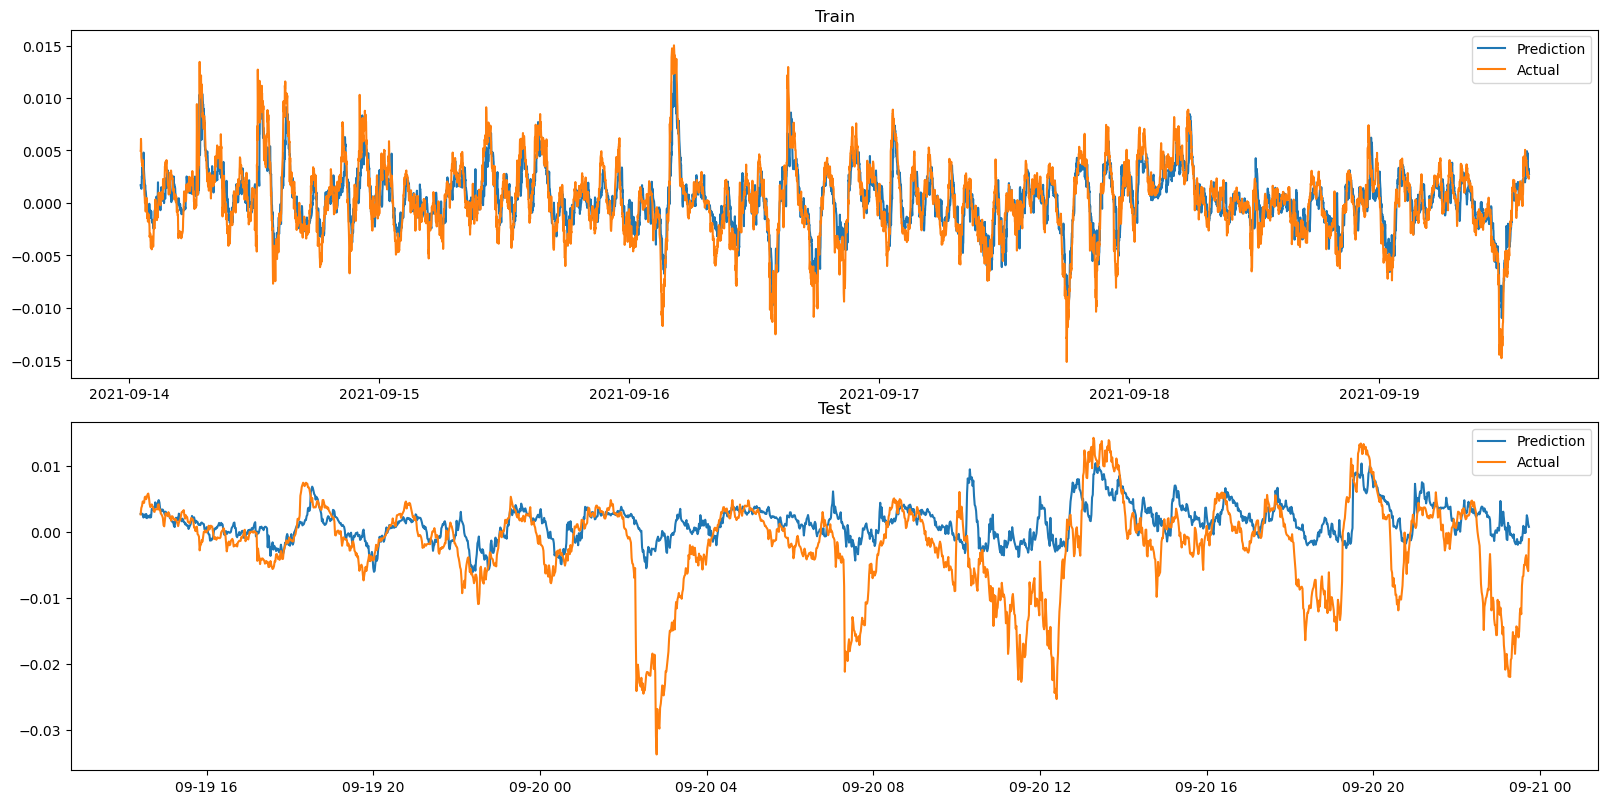

In [118]:
plt.rcParams.update({'figure.figsize': (16, 8), 'figure.dpi': 100})

fig, axes = plt.subplots(2, 1)
fig.tight_layout()

axes[0].plot(pred_train_series2, label='Prediction')
axes[0].plot(Y2_train, label='Actual')
axes[0].set_title('Train')
axes[0].legend()

axes[1].plot(pred_test_series2, label='Prediction')
axes[1].plot(Y2_test, label='Actual')
axes[1].set_title('Test')
axes[1].legend()

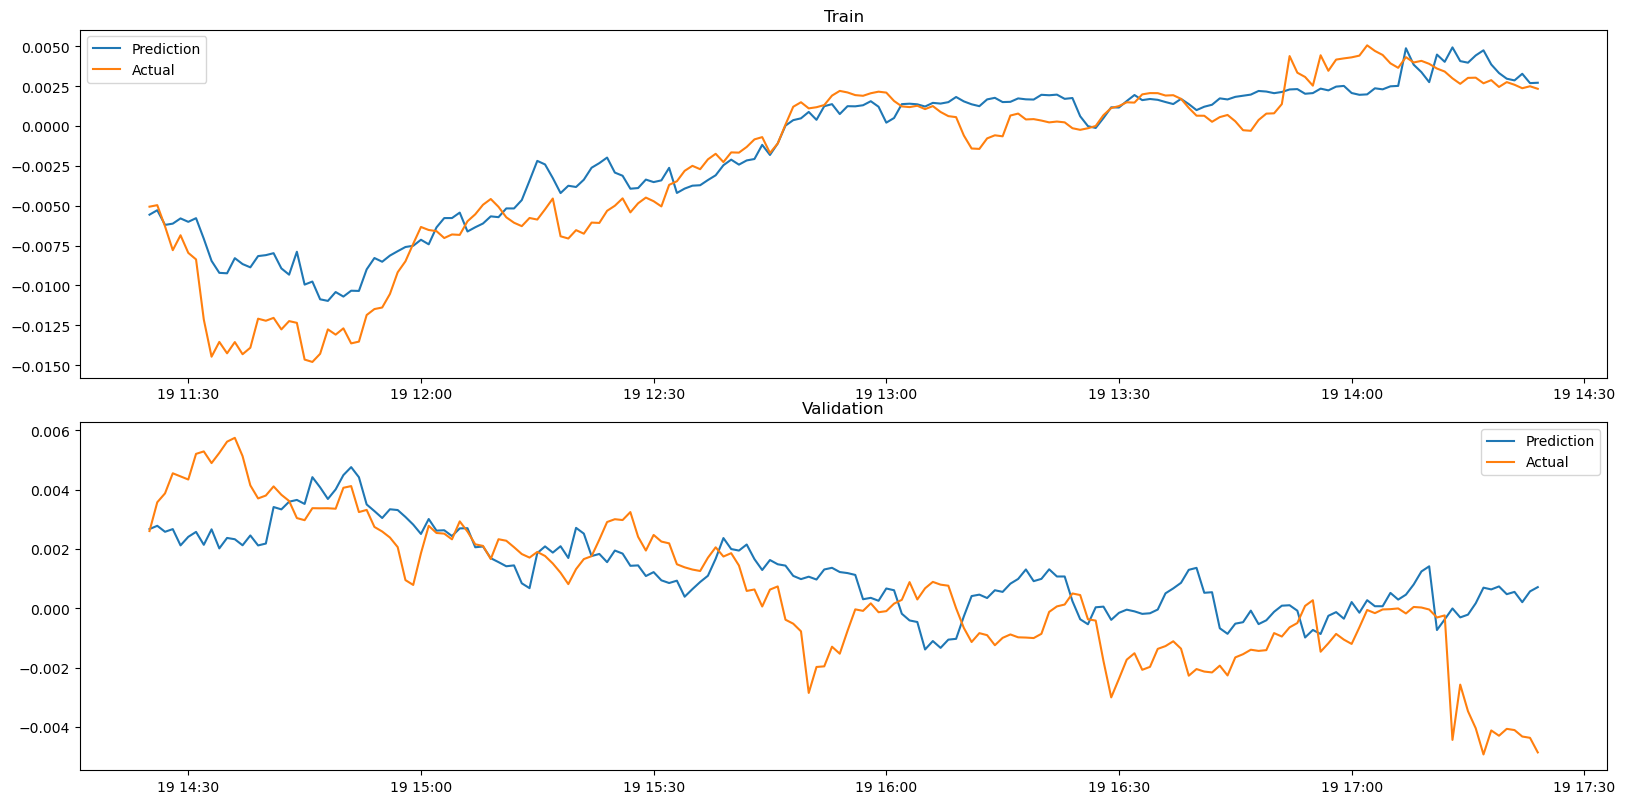

In [119]:
plt.rcParams.update({'figure.figsize': (16, 8), 'figure.dpi': 100})

fig, axes = plt.subplots(2, 1)
fig.tight_layout()

axes[0].plot(pred_train_series2.tail(180), label='Prediction')
axes[0].plot(Y2_train.tail(180), label='Actual')
axes[0].set_title('Train')
axes[0].legend()

axes[1].plot(pred_test_series2.head(180), label='Prediction')
axes[1].plot(Y2_test.head(180), label='Actual')
axes[1].set_title('Test')
axes[1].legend()

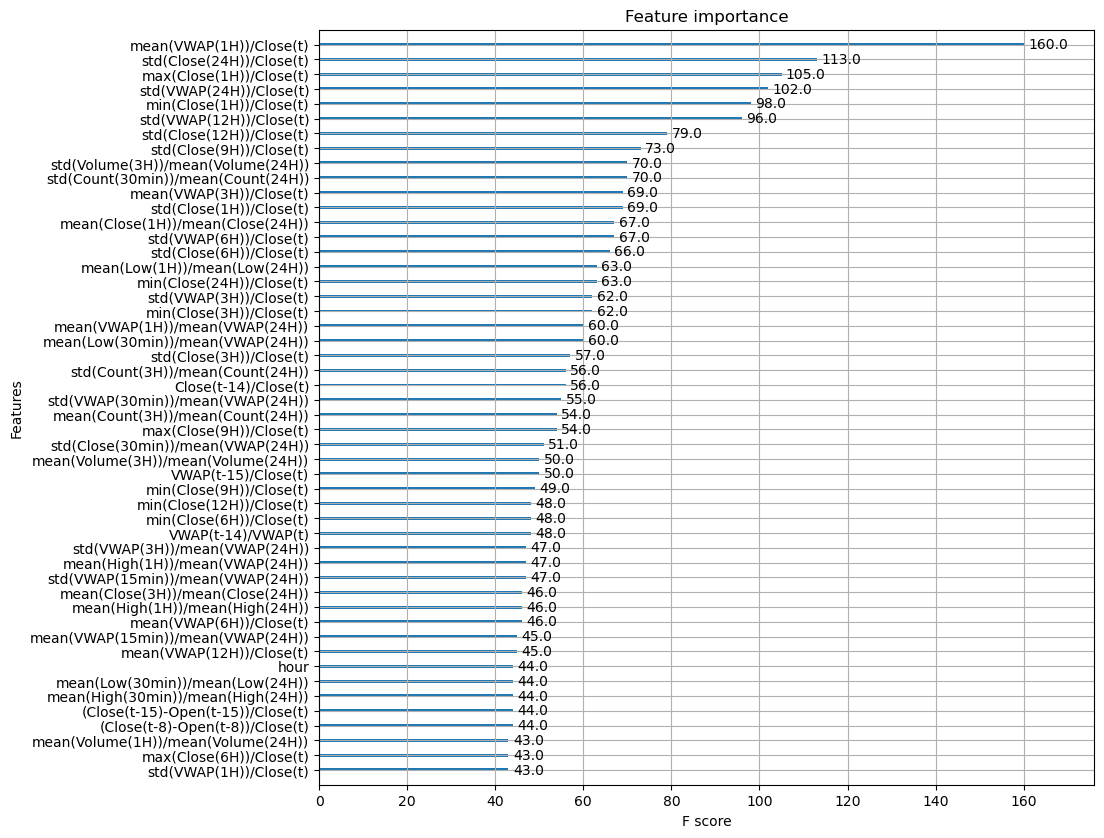

In [120]:
ax = xgboost.plot_importance(model2, max_num_features=50)
fig = ax.figure
fig.set_size_inches(10, 10)

### Close price prediction visualization

In [33]:
# pred_series2 = pd.concat([pred_train_series2, pred_test_series2])
# close_series2 = data_raw.Close.loc[data_1.index]
# target_series2 = data_1.Target2

In [34]:
# table2 = pd.DataFrame({'initial target': target_series2, 'predicted target': pred_series2, 'actual close': close_series2})

In [35]:
# table2['mean(Close(1H))']=data_raw.Close.rolling('1H').mean()
# table2['Close(t+15)']=(table2['initial target']+1)*table2['mean(Close(1H))']
# table2['predicted Close(t+15)']=(table2['predicted target']+1)*table2['mean(Close(1H))']
# table2

,initial target,predicted target,actual close,mean(Close(1H)),Close(t+15),predicted Close(t+15)
timestamp,,,,,,
2021-09-14 01:05:00,0.004974,0.001688,45135.727143,45067.694199,45291.874286,45143.768627
2021-09-14 01:06:00,0.005087,0.001602,45129.775714,45069.581771,45298.868508,45141.780286
2021-09-14 01:07:00,0.006106,0.001517,45138.098571,45072.839461,45348.035714,45141.190681
2021-09-14 01:08:00,0.005695,0.001384,45131.365714,45077.190914,45333.891429,45139.557146
2021-09-14 01:09:00,0.004365,0.001363,45124.667143,45080.713643,45277.501429,45142.149667
...,...,...,...,...,...,...
2021-09-20 23:40:00,-0.003587,0.000766,42703.636250,43139.958154,42985.214824,43173.005040
2021-09-20 23:41:00,-0.005168,0.002467,42781.970571,43121.878747,42899.012857,43228.246563
2021-09-20 23:42:00,-0.005654,0.002007,42755.592500,43103.707812,42860.005714,43190.237835


In [36]:
# table2.to_csv('table2.csv')

In [15]:
table2 = pd.read_csv('table2.csv')
table2

,timestamp,initial target,predicted target,actual close,mean(Close(1H)),Close(t+15),predicted Close(t+15)
0,2021-09-14 01:05:00,0.004974,0.001688,45135.727143,45067.694199,45291.874286,45143.768627
1,2021-09-14 01:06:00,0.005087,0.001602,45129.775714,45069.581771,45298.868508,45141.780286
2,2021-09-14 01:07:00,0.006106,0.001517,45138.098571,45072.839461,45348.035714,45141.190681
3,2021-09-14 01:08:00,0.005695,0.001384,45131.365714,45077.190914,45333.891429,45139.557146
4,2021-09-14 01:09:00,0.004365,0.001363,45124.667143,45080.713643,45277.501429,45142.149667
...,...,...,...,...,...,...,...
9995,2021-09-20 23:40:00,-0.003587,0.000766,42703.636250,43139.958154,42985.214824,43173.005040
9996,2021-09-20 23:41:00,-0.005168,0.002467,42781.970571,43121.878747,42899.012857,43228.246563
9997,2021-09-20 23:42:00,-0.005654,0.002007,42755.592500,43103.707812,42860.005714,43190.237835
9998,2021-09-20 23:43:00,-0.005994,0.001095,42717.234286,43085.273408,42827.020000,43132.438809


In [16]:
table2['predicted Close(t+15)'] = table2['predicted Close(t+15)'].shift(-15)
table2['predicted target'] = table2['predicted target'].shift(-15)

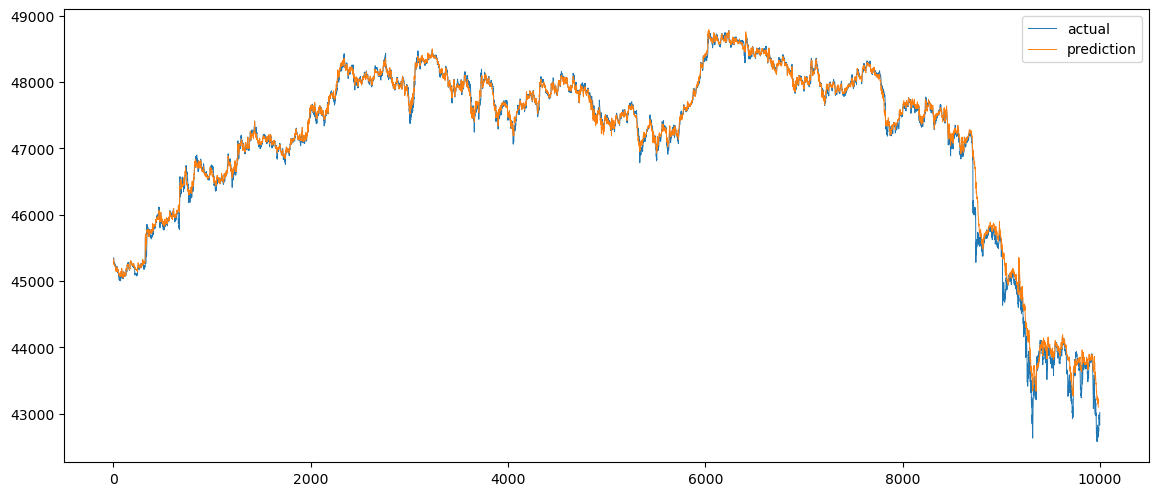

In [17]:
plt.rcParams.update({'figure.figsize':(14,6), 'figure.dpi':100, 'lines.linewidth': 0.7})

table2['Close(t+15)'].plot(label='actual')
table2['predicted Close(t+15)'].plot(label='prediction')

plt.legend()
plt.show()

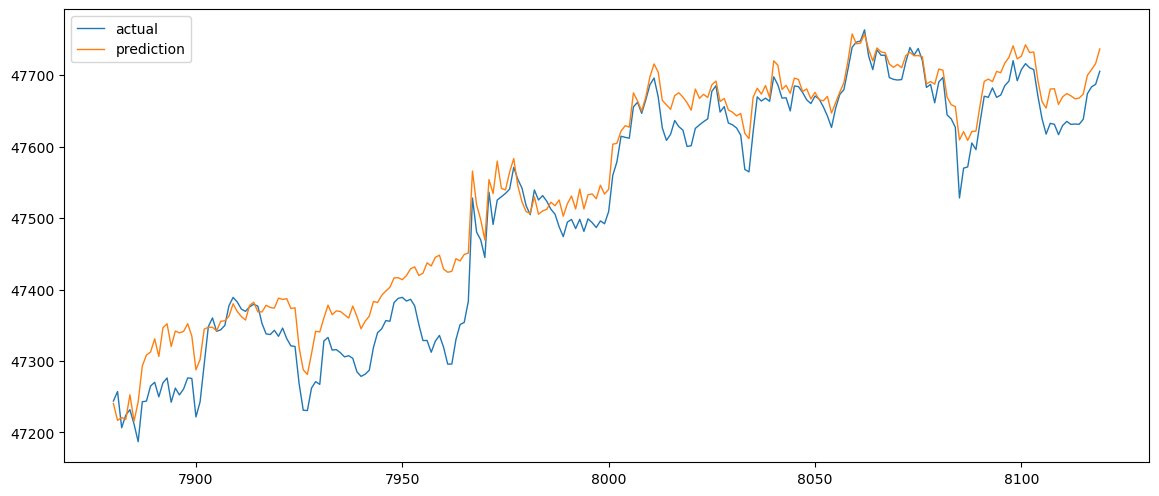

In [18]:
plt.rcParams.update({'figure.figsize':(14,6), 'figure.dpi':100, 'lines.linewidth': 1})

table2['Close(t+15)'].iloc[7880:8120].plot(label='actual')
table2['predicted Close(t+15)'].iloc[7880:8120].plot(label='prediction')

plt.legend()
plt.show()

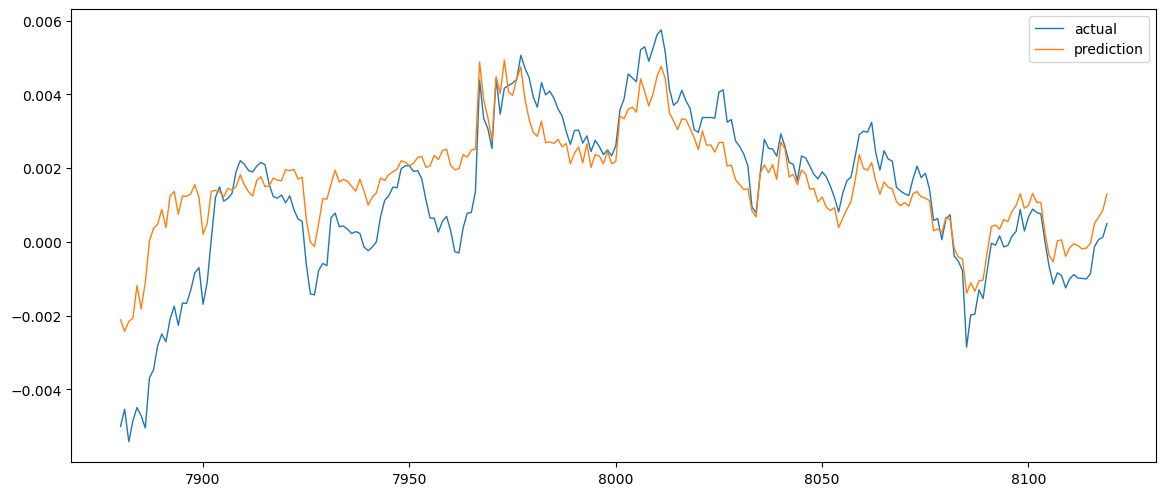

In [19]:
plt.rcParams.update({'figure.figsize':(14,6), 'figure.dpi':100, 'lines.linewidth': 1})

table2['initial target'].iloc[7880:8120].plot(label='actual')
table2['predicted target'].iloc[7880:8120].plot(label='prediction')

plt.legend()
plt.show()